This script is for plotting novel GUESS results using plotgardener

Now also plotting GWAS loci (see end).

TLR5, GRB2...

In [1]:
library(data.table)
library("plotgardener")
library("org.Hs.eg.db")
library("TxDb.Hsapiens.UCSC.hg38.knownGene")
library(png)
options(bedtools.path = "/rds/general/user/hrayjone/home/anaconda3/bin/")
library(bedtoolsr)
setwd("~/HRJ_monocytes/leo_triplets/")


Attaching package: ‘plotgardener’


The following object is masked from ‘package:base’:

    c


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'cit

Process the GUESS data to make it easier to plot in hg38

In [2]:
guess <- fread("./results/mar23/filtered/final_biorxiv/final_GUESS_results_DpnII_distal_betas_AI_CORRECTED.txt")

### add hg38 SNP positions and peak locations
#str(guess)
guesshg38 <- fread("./results/mar23/filtered/final_biorxiv/final_GUESS_results_DpnII_distal_betas_AI_hg38_forRemap_CORRECTED.txt")
#str(guesshg38)

guess_hg38 <- guesshg38[guess, on = "Post-proc. FDR mPPI SNP single", nomatch = NULL]
length(unique(guess_hg38$`Post-proc. FDR mPPI SNP single`))

# column "position" is the hg38 position of the SNP
guess_hg38[, position0 := position - 1]

# Add in the ATAC locations
guess_hg38[, ATAC_feature := tstrsplit(`Triplet name`, split = "/", keep = 2)]
locs <- fread("./input/alex_inputs/ATAC_gene_locations.csv")
locs[, c("V1", "chr") := NULL]
setnames(locs, c("geneid", "left", "right"), c("ATAC_feature", "ATAC_left", "ATAC_right"))
peaks <- unique(locs)

guess_hg38_peaks <- peaks[guess_hg38, on  = "ATAC_feature", nomatch = NULL]
length(unique(guess_hg38$ATAC_feature))
length(unique(guess_hg38_peaks$ATAC_feature))

#guess_hg38_peaks

### Get sets bed file for Leo's analysis
sets <- fread("~/HRJ_monocytes/leo_triplets/input/alex_inputs/Helen_SNP_sets.txt")
snplocs <- read.csv("~/HRJ_monocytes/leo_triplets/input/alex_inputs/snp_chromlocations.csv")
snplocs <- as.data.table(snplocs)
setkey(snplocs, annot)
sets_locs <- sets[snplocs, on = c(hg19_ID = "annot"), nomatch = NULL]
#sets_locs
sets_locs[, position0 := position-1]
sets_bed <- sets_locs[, .(chrom, position0, position, hg19_ID, set)]



[1] 614

Warning message in fread("./input/alex_inputs/ATAC_gene_locations.csv"):
“Detected 4 column names but the data has 5 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 298

[1] 298

In [3]:
## bring in the regions that were tested in BaseQTL. for each proxy SNP, we can filter this file and merge the gene end to make one PE contact.
regions <- fread("/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/AS_CHiC/BaseQTL/scripts/bedpe_for_chic_egenes_with_Gene_number.txt")
regions[, chrom1 := paste0("chr", V1)]
regions[, chrom2 := paste0("chr", V4)]

In [4]:
## bring in the original eQTLs in hg38
trueDistal <- fread("~/eCHiC/design/final_design/V02_final_filtered_eqtls_illumina_july19_hg38_Jan20.txt")
str(trueDistal)

Classes ‘data.table’ and 'data.frame':	11280 obs. of  42 variables:
 $ Chrom            : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ RegBuild_start   : int  107028601 NA NA NA NA NA 108050200 109633602 109639401 109633602 ...
 $ RegBuild_end     : int  107031800 NA NA NA NA NA 108052401 109637121 109641800 109637121 ...
 $ Feature          : chr  "Promoter Flanking Region" NA NA NA ...
 $ Feature_descrip  : chr  "Predicted promoter flanking region" NA NA NA ...
 $ hg19SNP_ID       : chr  "1:107565934:G:A" "1:107565934:G:A" "1:1005806:C:T" "1:1005806:C:T" ...
 $ hg38SNP_ID       : chr  "1:107023312:G:A" "1:107023312:G:A" "1:1070426:C:T" "1:1070426:C:T" ...
 $ hg38SNP_pos      : int  107023312 107023312 1070426 1070426 1070426 1070426 108048560 109633938 109633938 109633938 ...
 $ SNP_MAF          : num  0.331 0.331 0.168 0.168 0.168 ...
 $ hg19Proxy_ID     : chr  "1:107572997:T:C" "1:107565934:G:A" "1:1005806:C:T" "1:1005806:C:T" ...
 $ hg38Proxy_ID     : chr  "1:107030375:T:C" "1:10702331

In [9]:
length(unique(guess$`Post-proc. FDR mPPI SNP single`))
length(unique(guess$`Post-proc. FDR mPPI SNP`))

[1] 614

[1] 594

Plot the TLR5 locus

In [5]:
#guess[`Triplet name` %like% "TLR5"]
cd14 <- fread("~/eCHiC/design/source/cd14_eqtls_no_freq.txt")
cd14[hgnc %like% "TLR5"]

unique(trueDistal[Gene %like% "TLR5", hg38SNP_ID, hg19SNP_ID]) # this is the one we care about

probe_id,hgnc,chrom,snp_pos,snp_id,beta,beta_wrt_minor,p_value,FDR,indep_signal_i,ensembl_gid,n_samples,maf,hwe_pvalue,imputation_score
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
830440,TLR5,1,223273813,1:223273813:T:C,0.08971390,-0.08971390,8.823570e-19,9.983715e-15,0,ENSG00000187554,3201,0.1842105,0.7003300,0.890002
830440,TLR5,1,223337508,1:223337508:T:C,-0.05105124,-0.05105124,5.928051e-09,8.849270e-05,1,ENSG00000187554,3201,0.3018576,0.8806048,0.997488


hg19SNP_ID,hg38SNP_ID
<chr>,<chr>
1:223337508:T:C,1:223164166:T:C


[1] 19

[1] 1733

In [53]:
str(base_hg38)

Classes ‘data.table’ and 'data.frame':	1880 obs. of  24 variables:
 $ hg19Proxy_ID : chr  "1:108593895:A:G" "1:110176560:G:A" "1:110176847:T:C" "1:110182405:T:C" ...
 $ Chrom        : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ hg38Proxy_pos: int  108051273 109633938 109634225 109639783 109662028 110310022 111193767 111193767 111194561 111194561 ...
 $ int_id       : chr  "1:108593895:A:G_ENSG00000134215_VAV3-1:108593895:A:G" "1:110176560:G:A_ENSG00000168765_GSTM4-1:110176560:G:A" "1:110176847:T:C_ENSG00000168765_GSTM4-1:110176847:T:C" "1:110182405:T:C_ENSG00000168765_GSTM4-1:110182405:T:C" ...
 $ log_mean_aFC : num  0.00154 0.02664 -0.02347 0.14448 -0.02992 ...
 $ se_mean      : num  0.00149 0.00388 0.00337 0.00629 0.00342 ...
 $ sd           : num  0.0768 0.1761 0.191 0.1901 0.2003 ...
 $ 0.5%         : num  -0.274 -0.526 -0.689 -0.197 -0.719 ...
 $ 2.5%         : num  -0.1679 -0.3636 -0.4856 -0.0744 -0.5132 ...
 $ 25%          : num  -0.02727 -0.02991 -0.05176 0.00115 -0.06243 ...
 $ 50

In [5]:
trueDistal <- fread("~/eCHiC/design/final_design/V02_final_filtered_eqtls_illumina_july19_hg38_Jan20.txt")
str(trueDistal)

Classes ‘data.table’ and 'data.frame':	11280 obs. of  42 variables:
 $ Chrom            : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ RegBuild_start   : int  107028601 NA NA NA NA NA 108050200 109633602 109639401 109633602 ...
 $ RegBuild_end     : int  107031800 NA NA NA NA NA 108052401 109637121 109641800 109637121 ...
 $ Feature          : chr  "Promoter Flanking Region" NA NA NA ...
 $ Feature_descrip  : chr  "Predicted promoter flanking region" NA NA NA ...
 $ hg19SNP_ID       : chr  "1:107565934:G:A" "1:107565934:G:A" "1:1005806:C:T" "1:1005806:C:T" ...
 $ hg38SNP_ID       : chr  "1:107023312:G:A" "1:107023312:G:A" "1:1070426:C:T" "1:1070426:C:T" ...
 $ hg38SNP_pos      : int  107023312 107023312 1070426 1070426 1070426 1070426 108048560 109633938 109633938 109633938 ...
 $ SNP_MAF          : num  0.331 0.331 0.168 0.168 0.168 ...
 $ hg19Proxy_ID     : chr  "1:107572997:T:C" "1:107565934:G:A" "1:1005806:C:T" "1:1005806:C:T" ...
 $ hg38Proxy_ID     : chr  "1:107030375:T:C" "1:10702331

In [46]:
str(base_hg38)

Classes ‘data.table’ and 'data.frame':	12312 obs. of  24 variables:
 $ hg19Proxy_ID : chr  "1:108593895:A:G" "1:109707911:T:C" "1:109708064:A:G" "1:109709032:G:A" ...
 $ Chrom        : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ hg38Proxy_pos: int  108051273 109165289 109165442 109166410 109168641 109168775 109169401 109171276 109171395 109171492 ...
 $ int_id       : chr  "1:108593895:A:G_ENSG00000134215_VAV3-1:108593895:A:G" "1:109707911:T:C_ENSG00000116299_KIAA1324-1:109707911:T:C" "1:109708064:A:G_ENSG00000116299_KIAA1324-1:109708064:A:G" "1:109709032:G:A_ENSG00000116299_KIAA1324-1:109709032:G:A" ...
 $ log_mean_aFC : num  0.00154 -0.00919 -0.27119 -0.02453 0.04136 ...
 $ se_mean      : num  0.00149 0.00224 0.00924 0.00277 0.00343 ...
 $ sd           : num  0.0768 0.1023 0.2965 0.128 0.1541 ...
 $ 0.5%         : num  -0.274 -0.402 -1.091 -0.496 -0.412 ...
 $ 2.5%         : num  -0.168 -0.272 -0.913 -0.355 -0.258 ...
 $ 25%          : num  -0.0273 -0.0328 -0.4961 -0.0469 -0.0223 ...
 $ 

In [40]:
base

int_id,log_mean_aFC,se_mean,sd,0.5%,2.5%,25%,50%,75%,97.5%,⋯,Rhat,Signif.99,PEP,AI_estimate,counts,model,Signif.95,norm_approx,SNP,ENSG_ID
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>
1:108593895:A:G_ENSG00000134215_VAV3-1:108593895:A:G,0.001544558,0.001486968,0.07683191,-0.2736049,-0.16787686,-0.02726920,-0.0002299005,0.026582961,0.20047174,⋯,0.9998195,no,0.50225,0.4989247,739,NB-ASE,no,0.49198057,1:108593895:A:G,ENSG00000134215
1:109707911:T:C_ENSG00000116299_KIAA1324-1:109707911:T:C,-0.009194321,0.002238452,0.10234592,-0.4023719,-0.27155610,-0.03280400,-0.0021886884,0.025756689,0.21519428,⋯,1.0001282,no,0.47375,0.4927114,273,NB-ASE,no,0.46420887,1:109707911:T:C,ENSG00000116299
1:109708064:A:G_ENSG00000116299_KIAA1324-1:109708064:A:G,-0.271186881,0.009241957,0.29652826,-1.0914307,-0.91346982,-0.49612945,-0.2154058845,-0.013432451,0.08467856,⋯,1.0018750,no,0.19100,0.1445783,51,NB-ASE,no,0.18021665,1:109708064:A:G,ENSG00000116299
1:109709032:G:A_ENSG00000116299_KIAA1324-1:109709032:G:A,-0.024528318,0.002769886,0.12802147,-0.4964218,-0.35464516,-0.04693013,-0.0065656625,0.024963042,0.23080885,⋯,1.0001751,no,0.44350,0.5000000,226,NB-ASE,no,0.42402959,1:109709032:G:A,ENSG00000116299
1:109711263:A:G_ENSG00000116299_KIAA1324-1:109711263:A:G,0.041362860,0.003425383,0.15407555,-0.4119985,-0.25799204,-0.02233683,0.0111703784,0.066047542,0.43397174,⋯,1.0021169,no,0.40975,0.5000000,112,NB-ASE,no,0.39417329,1:109711263:A:G,ENSG00000116299
1:109711397:T:A_ENSG00000116299_KIAA1324-1:109711397:T:A,-0.038815192,0.003410516,0.14037560,-0.5772507,-0.41100628,-0.05686174,-0.0109319706,0.020531024,0.21155799,⋯,1.0007093,no,0.41425,0.5000000,179,NB-ASE,no,0.39107836,1:109711397:T:A,ENSG00000116299
1:109712023:A:G_ENSG00000116299_KIAA1324-1:109712023:A:G,-0.020612637,0.003442256,0.14565221,-0.5478209,-0.39155879,-0.04580488,-0.0050847039,0.029006748,0.29609414,⋯,1.0005327,no,0.46075,0.3229167,179,NB-ASE,no,0.44372975,1:109712023:A:G,ENSG00000116299
1:109713898:A:G_ENSG00000116299_KIAA1324-1:109713898:A:G,-0.207692708,0.006452992,0.21133263,-0.7664494,-0.66009389,-0.36729603,-0.1806717053,-0.018269617,0.05492497,⋯,1.0025158,no,0.16625,0.4228188,238,NB-ASE,no,0.16285877,1:109713898:A:G,ENSG00000116299
1:109714017:T:C_ENSG00000116299_KIAA1324-1:109714017:T:C,-0.026101690,0.003526293,0.14325832,-0.5413720,-0.40598185,-0.04947925,-0.0068323726,0.025893035,0.27644623,⋯,1.0012890,no,0.44250,0.2363636,228,NB-ASE,no,0.42771282,1:109714017:T:C,ENSG00000116299


In [40]:
TLR5$position

[1] 223177259

In [46]:
str(TLR5)

Classes ‘data.table’ and 'data.frame':	1 obs. of  28 variables:
 $ ATAC_feature                              : chr "Peak_76308"
 $ ATAC_left                                 : int 223174630
 $ ATAC_right                                : int 223177740
 $ Post-proc. FDR mPPI SNP single            : chr "1:223350601:C:G"
 $ chrom                                     : chr "chr1"
 $ position                                  : int 223177259
 $ Triplet ID                                : int 4481
 $ Triplet name                              : chr "X518322_ENSG00000187554_TLR5/Peak_76308/ENSG00000187554_TLR5"
 $ Numb. SNP                                 : chr "10"
 $ Post-proc. total post. mass               : num 0.984
 $ Post-proc. best model SNP                 : chr "1:223350601:C:G"
 $ Post-proc. best model size                : int 1
 $ Post-proc. best model post. prob.         : num 0.982
 $ Post-proc. best model post. mean Beta     : chr "-0.12,-0.028,-0.027"
 $ Post-proc. max mPPI SNP 

In [33]:
# we can show the most confident model and show the second model if we think it is interesting?
TLR5 <- guess_hg38_peaks[`Triplet name` %like% "TLR5" & `Post-proc. FDR mPPI SNP single` == "1:223350601:C:G"]

pdf(file = "~/HRJ_monocytes/paper/TLR5_plotGardenerGUESS.pdf")

### Set region parameters
mychrom = "chr1"
mystart = 223084661
myend = 223234053
###

########## Set parameters main and text
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 3, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

########################## 
GUESSvarloc = TLR5$position # the most confident model
myGene = "TLR5"
myset = TLR5$`Triplet ID`
mypeakstart = TLR5$ATAC_left
mypeakend = TLR5$ATAC_right
mybait = "518322"
###
mysetbed <- sets_bed[set == myset]
### original eQTL (See above)
myeQTLpos <- 223164166

### restrict called regions to that in BaseQTL
regions_keep1 <- regions[V7 %like% mybait & V7 %like% myGene] 
regions_keep_LHS1 <- regions_keep1[, .(chrom1, V2, V3)]
regions_keep_RHS1 <- regions_keep1[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort1 <- setorder(regions_keep_RHS1, cols = "V5")
regions_keep_LHS_merge1 <- regions_keep_LHS1[1:2, ]
RHS_merge1 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort1, d = 1)
LHS_merge1 <- bedtoolsr::bt.merge(regions_keep_LHS1, d = 1)
both_regions1 <- cbind(LHS_merge1, RHS_merge1)
#both_regions1

pageCreate(width = 16, height = 7, default.units = "cm", showGuides = F)

## specify the gene target
geneHighlights <- data.frame("geneName" = c(myGene), "color" = c("chartreuse4")) # 

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 3.5, height = 1)
# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 3.8, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6)

####################### LOOPS
## plot loops
archplot <- plotPairsArches(
    data = both_regions1, params = params_main, y = 4.5, height = 1.2, fill = "chartreuse4", linecolor = "fill", flip = TRUE
)

# text for loops
plotText(
    label = "Tested contacts", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 4.8, height = 0.5,
)
#######################

####################### EQTLS

### Plot GUESS QTLs
GUESS <- data.table(chrom = mychrom, start = GUESSvarloc - 1, end= GUESSvarloc)
plotRanges( 
    data = GUESS, params = params_main, linecolor="chartreuse4", fill = "chartreuse4", collapse = T,
    y = 2.5, height = 0.3
)
# text for QTLs
plotText(
    label = "GUESS best model SNP", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 2.5, height = 0.5,
)
### plot original eQTLs
GUESS <- data.table(chrom = mychrom, start = myeQTLpos - 1, end= myeQTLpos)
plotRanges( 
    data = GUESS, params = params_main, linecolor="gray40", fill = "gray40", collapse = T,
    y = 2, height = 0.3
)
# text for eQTLs
plotText(
    label = "Original lead eQTL", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2, height = 0.5,
)

#######################

####################### SETS

# Plot proxies
plotRanges( 
    data = mysetbed, params = params_main, linecolor="gray", fill = "gray", collapse = T,
    y = 3, height = 0.3
)
# text for proxies
plotText(
    label = "GUESS SNP set", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 3, height = 0.5
)
#######################

####################### ATAC
### wonder if I can plot all ATAC and highlight top?

atac_myregion <- readBigwig(file = "/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.8, units = "cm",
    linecolor = "gray40", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)

## plot ATAC top
atac_myregion <- readBigwig(file = "/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mypeakstart,
                        chromend = mypeakend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.8, units = "cm",
    linecolor = "chartreuse4", fill = "chartreuse4", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
# text for ATAC, non peak
plotText(
    label = "ATAC signal (-log10P)", fontsize = 7, fontcolor = "gray40",
    rot = 0, params = params_text, y = 0.9, height = 1
) 
# text for ATAC
plotText(
    label = "with GUESS peak", fontsize = 7, fontcolor = "chartreuse4",
    rot = 0, params = params_text, y = 1.3, height = 1
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,11), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 0.8, height = 1, fontsize = 7, fontcolor = "chartreuse4", units = "cm"
)

#######################

dev.off()



genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

arches[arches1]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

signal[signal1]

signal[signal2]

text[text2]

text[text2]

yaxis[yaxis1]



png 
  2

Plot the CAMK2D locus or the IFNGR1 locus



In [12]:
guess[`Triplet name` %like% "CAMK2D"]
unique(trueDistal[Gene %like% "CAMK2D", hg38SNP_ID])
# COULD DO THE MODEL 4:114706545:A:C,4:114709536:A:T FOR X4694175_ENSG00000145349_CAMK2D/Peak_109562/ENSG00000145349_CAMK2D

guess[`Triplet name` %like% "IFNGR1"]
guess[`Triplet name` %like% "IFNGR1", .(`Post-proc. FDR mPPI SNP`)]
unique(trueDistal[Gene %like% "IFNGR1", hg38SNP_ID])

# why does one of the SNPs in the model have beta= 0?? I need to remove all models where any FDR SNP had beta lower than our threshold... check the filtering script...
str(trueDistal)

Triplet ID,Triplet name,Numb. SNP,Post-proc. total post. mass,Post-proc. best model SNP,Post-proc. best model size,Post-proc. best model post. prob.,Post-proc. best model post. mean Beta,Post-proc. max mPPI SNP,Post-proc. max mPPI,⋯,Post-proc. FDR mPPI,Post-proc. FDR mPPI post. mean Beta,chic_feat,DpnID,Gene,Post-proc. FDR mPPI post. mean Beta perSNP,Post-proc. FDR mPPI SNP single,GUESS_chic_beta,GUESS_ATAC_beta,GUESS_RNA_beta
<int>,<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
6840,X4694183_ENSG00000145349_CAMK2D/Peak_109561/ENSG00000145349_CAMK2D,46,0.582,"4:114706545:A:C,4:114708329:C:G",2,0.486,"0.012,0.015,0.029,0.048,0.005,0.018",4:114708329:C:G,0.953,⋯,0.953,"0.048,0.005,0.018",4694183_ENSG00000145349_CAMK2D,4694183,ENSG00000145349_CAMK2D,"0.048,0.005,0.018",4:114708329:C:G,0.048,0.005,0.018
6842,X4694188_ENSG00000145349_CAMK2D/Peak_109561/ENSG00000145349_CAMK2D,46,0.711,"4:114709512:A:G,4:114711672:G:A",2,0.661,"-0.008,0.034,0.065,0.058,-0.006,0.019",4:114709512:A:G,1.000,⋯,"1,0.998","-0.008,0.034,0.065,0.058,-0.006,0.019",4694188_ENSG00000145349_CAMK2D,4694188,ENSG00000145349_CAMK2D,"-0.008,0.034,0.065",4:114709512:A:G,-0.008,0.034,0.065
6842,X4694188_ENSG00000145349_CAMK2D/Peak_109561/ENSG00000145349_CAMK2D,46,0.711,"4:114709512:A:G,4:114711672:G:A",2,0.661,"-0.008,0.034,0.065,0.058,-0.006,0.019",4:114709512:A:G,1.000,⋯,"1,0.998","-0.008,0.034,0.065,0.058,-0.006,0.019",4694188_ENSG00000145349_CAMK2D,4694188,ENSG00000145349_CAMK2D,"0.058,-0.006,0.019",4:114711672:G:A,0.058,-0.006,0.019
6843,X4694175_ENSG00000145349_CAMK2D/Peak_109562/ENSG00000145349_CAMK2D,37,0.903,"4:114706545:A:C,4:114709536:A:T",2,0.837,"0.009,0.01,0.025,-0.016,0.019,0.022",4:114709536:A:T,0.999,⋯,"0.999,0.964","-0.016,0.019,0.022,0.009,0.01,0.025",4694175_ENSG00000145349_CAMK2D,4694175,ENSG00000145349_CAMK2D,"-0.016,0.019,0.022",4:114709536:A:T,-0.016,0.019,0.022
6843,X4694175_ENSG00000145349_CAMK2D/Peak_109562/ENSG00000145349_CAMK2D,37,0.903,"4:114706545:A:C,4:114709536:A:T",2,0.837,"0.009,0.01,0.025,-0.016,0.019,0.022",4:114709536:A:T,0.999,⋯,"0.999,0.964","-0.016,0.019,0.022,0.009,0.01,0.025",4694175_ENSG00000145349_CAMK2D,4694175,ENSG00000145349_CAMK2D,"0.009,0.01,0.025",4:114706545:A:C,0.009,0.010,0.025
6844,X4694181_ENSG00000145349_CAMK2D/Peak_109562/ENSG00000145349_CAMK2D,37,0.641,"4:114708383:A:G,4:114710727:C:T",2,0.587,"-0.013,0.009,0.023,0.034,0.02,0.021",4:114710727:C:T,1.000,⋯,"1,0.965","0.034,0.02,0.021,-0.013,0.009,0.023",4694181_ENSG00000145349_CAMK2D,4694181,ENSG00000145349_CAMK2D,"0.034,0.02,0.021",4:114710727:C:T,0.034,0.020,0.021
6844,X4694181_ENSG00000145349_CAMK2D/Peak_109562/ENSG00000145349_CAMK2D,37,0.641,"4:114708383:A:G,4:114710727:C:T",2,0.587,"-0.013,0.009,0.023,0.034,0.02,0.021",4:114710727:C:T,1.000,⋯,"1,0.965","0.034,0.02,0.021,-0.013,0.009,0.023",4694181_ENSG00000145349_CAMK2D,4694181,ENSG00000145349_CAMK2D,"-0.013,0.009,0.023",4:114708383:A:G,-0.013,0.009,0.023
6845,X4694183_ENSG00000145349_CAMK2D/Peak_109562/ENSG00000145349_CAMK2D,37,0.586,"4:114706545:A:C,4:114715600:G:A",2,0.567,"0.011,0.012,0.029,0.054,0.019,0.019","4:114715600:G:A,4:114706545:A:C",1.000,⋯,"1,1","0.054,0.019,0.019,0.011,0.012,0.029",4694183_ENSG00000145349_CAMK2D,4694183,ENSG00000145349_CAMK2D,"0.054,0.019,0.019",4:114715600:G:A,0.054,0.019,0.019
6845,X4694183_ENSG00000145349_CAMK2D/Peak_109562/ENSG00000145349_CAMK2D,37,0.586,"4:114706545:A:C,4:114715600:G:A",2,0.567,"0.011,0.012,0.029,0.054,0.019,0.019","4:114715600:G:A,4:114706545:A:C",1.000,⋯,"1,1","0.054,0.019,0.019,0.011,0.012,0.029",4694183_ENSG00000145349_CAMK2D,4694183,ENSG00000145349_CAMK2D,"0.011,0.012,0.029",4:114706545:A:C,0.011,0.012,0.029


[1] "4:113418295:G:A" "4:113788380:A:T" "4:113832279:A:G"

Triplet ID,Triplet name,Numb. SNP,Post-proc. total post. mass,Post-proc. best model SNP,Post-proc. best model size,Post-proc. best model post. prob.,Post-proc. best model post. mean Beta,Post-proc. max mPPI SNP,Post-proc. max mPPI,⋯,Post-proc. FDR mPPI,Post-proc. FDR mPPI post. mean Beta,chic_feat,DpnID,Gene,Post-proc. FDR mPPI post. mean Beta perSNP,Post-proc. FDR mPPI SNP single,GUESS_chic_beta,GUESS_ATAC_beta,GUESS_RNA_beta
<int>,<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
7453,X5629664_ENSG00000027697_IFNGR1/Peak_130441/ENSG00000027697_IFNGR1,34,0.499,"6:137672223:A:C,6:137672399:G:C,6:137672440:G:A",3,0.499,"-0.011,0.017,0.01,0,-0.002,-0.009,0.009,-0.028,0.036",6:137672223:A:C,1,⋯,"1,0.993,0.98","-0.011,0.017,0.01,0,-0.002,-0.009,0.009,-0.028,0.036",5629664_ENSG00000027697_IFNGR1,5629664,ENSG00000027697_IFNGR1,"-0.011,0.017,0.01",6:137672223:A:C,-0.011,0.017,0.010
7453,X5629664_ENSG00000027697_IFNGR1/Peak_130441/ENSG00000027697_IFNGR1,34,0.499,"6:137672223:A:C,6:137672399:G:C,6:137672440:G:A",3,0.499,"-0.011,0.017,0.01,0,-0.002,-0.009,0.009,-0.028,0.036",6:137672223:A:C,1,⋯,"1,0.993,0.98","-0.011,0.017,0.01,0,-0.002,-0.009,0.009,-0.028,0.036",5629664_ENSG00000027697_IFNGR1,5629664,ENSG00000027697_IFNGR1,"0.009,-0.028,0.036",6:137672440:G:A,0.009,-0.028,0.036


Post-proc. FDR mPPI SNP
<chr>
"6:137672223:A:C,6:137672399:G:C,6:137672440:G:A"
"6:137672223:A:C,6:137672399:G:C,6:137672440:G:A"


[1] "6:137304783:T:G"

Classes ‘data.table’ and 'data.frame':	11280 obs. of  42 variables:
 $ Chrom            : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ RegBuild_start   : int  107028601 NA NA NA NA NA 108050200 109633602 109639401 109633602 ...
 $ RegBuild_end     : int  107031800 NA NA NA NA NA 108052401 109637121 109641800 109637121 ...
 $ Feature          : chr  "Promoter Flanking Region" NA NA NA ...
 $ Feature_descrip  : chr  "Predicted promoter flanking region" NA NA NA ...
 $ hg19SNP_ID       : chr  "1:107565934:G:A" "1:107565934:G:A" "1:1005806:C:T" "1:1005806:C:T" ...
 $ hg38SNP_ID       : chr  "1:107023312:G:A" "1:107023312:G:A" "1:1070426:C:T" "1:1070426:C:T" ...
 $ hg38SNP_pos      : int  107023312 107023312 1070426 1070426 1070426 1070426 108048560 109633938 109633938 109633938 ...
 $ SNP_MAF          : num  0.331 0.331 0.168 0.168 0.168 ...
 $ hg19Proxy_ID     : chr  "1:107572997:T:C" "1:107565934:G:A" "1:1005806:C:T" "1:1005806:C:T" ...
 $ hg38Proxy_ID     : chr  "1:107030375:T:C" "1:10702331

Plot GRB2

In [100]:
unique(trueDistal[Gene %like% "GRB2", hg38SNP_ID, hg19SNP_ID])


cd14 <- fread("~/eCHiC/design/source/cd14_eqtls_no_freq.txt")
cd14[hgnc %like% "GRB2"]

guess[`Triplet name` %like% "X2651338_ENSG00000177885_GRB2/Peak_49683/ENSG00000177885_GRB2", c("Post-proc. FDR mPPI SNP", "Post-proc. FDR mPPI", 
                                                                                               "Post-proc. best model post. prob.")]
# region in chr17:75269867-75429646

# OK interestingly there are two lead eQTLs, one further to the right has a negative effect on GRB2 expression and one on left has positivie effect
# we also see the same in our SNPS; the first is +ve and the second is -ve.
# what is the LD?
# look at this.

# orig snps are 17:73304710:C:A, rs12936583 and 17:73309338:A:G, rs55762977 - these are in LD with R2 0.99
# Trip QTLs are 17:73304710:C:A, rs12936583 and 17:73307540:C:T, rs62090276 - these are not in strong LD, R2 0.59
# rs62090276 and rs55762977, which have the same direction of effect, are not in tight LD (R2 = 0.59), but are in closer physical proximity.
# the eQTL effects are corroborated in fiveX.
str(guess)

cd14[hgnc %like% "BST1"]

cd14[hgnc %like% "EID2"]
cd14[hgnc %like% "NCOR1"]


hg19SNP_ID,hg38SNP_ID
<chr>,<chr>
17:73304710:C:A,17:75308629:C:A


probe_id,hgnc,chrom,snp_pos,snp_id,beta,beta_wrt_minor,p_value,FDR,indep_signal_i,ensembl_gid,n_samples,maf,hwe_pvalue,imputation_score
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
7380725,GRB2,17,73309338,17:73309338:A:G,-0.08130527,-0.08130527,0.0000000000000000008686673,0.00000000000000295755,0,ENSG00000177885,943,0.2770898,0.1824684,0.989789
940039,GRB2,17,73304710,17:73304710:C:A,0.03307351,-0.03307351,0.0000001347039661600684967,0.00027042072038606905,0,ENSG00000177885,943,0.2801858,0.2293673,0.995746


Post-proc. FDR mPPI SNP,Post-proc. FDR mPPI,Post-proc. best model post. prob.
<chr>,<chr>,<dbl>
"17:73304710:C:A,17:73307540:C:T","0.999,0.996",0.926
"17:73304710:C:A,17:73307540:C:T","0.999,0.996",0.926


Classes ‘data.table’ and 'data.frame':	960 obs. of  23 variables:
 $ Triplet ID                                : int  145 148 150 151 154 155 156 157 158 159 ...
 $ Triplet name                              : chr  "X617387_ENSG00000123240_OPTN/Peak_168333/ENSG00000123240_OPTN" "X617519_ENSG00000123240_OPTN/Peak_168336/ENSG00000123240_OPTN" "X617527_ENSG00000123240_OPTN/Peak_168336/ENSG00000123240_OPTN" "X617536_ENSG00000123240_OPTN/Peak_168336/ENSG00000123240_OPTN" ...
 $ Numb. SNP                                 : chr  "17" "20" "20" "20" ...
 $ Post-proc. total post. mass               : num  0.924 0.953 0.943 0.879 0.989 0.959 0.916 0.98 0.927 0.977 ...
 $ Post-proc. best model SNP                 : chr  "10:13159899:C:G,10:13160212:T:C" "10:13199611:C:T,10:13200057:A:C" "10:13199611:C:T,10:13200057:A:C" "10:13199611:C:T,10:13200057:A:C" ...
 $ Post-proc. best model size                : int  2 2 2 2 2 1 1 1 1 1 ...
 $ Post-proc. best model post. prob.         : num  0.35 0.334 0.26

probe_id,hgnc,chrom,snp_pos,snp_id,beta,beta_wrt_minor,p_value,FDR,indep_signal_i,ensembl_gid,n_samples,maf,hwe_pvalue,imputation_score
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
6270681,BST1,4,15730146,4:15730146:G:T,-0.14616229,0.14616229,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000615806,0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000005891505,0,ENSG00000109743,6187,0.4411765,0.3827241,0.990410
6270681,BST1,4,15593692,4:15593692:C:T,0.04878345,0.04878345,0.0000000000000945256493722542691319541749933891333819175467612083707535930443555116653442382812500000,0.000000004464865491790561557695280321634775932970740086602745577692985534667968750000000000000000,1,ENSG00000109743,6187,0.4318885,0.6101280,0.997303


probe_id,hgnc,chrom,snp_pos,snp_id,beta,beta_wrt_minor,p_value,FDR,indep_signal_i,ensembl_gid,n_samples,maf,hwe_pvalue,imputation_score
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1430475,EID2,19,39915758,19:39915758:C:G,0.03727029,-0.03727029,0.0000005744675,0.005453221,0,ENSG00000176396,4912,0.495356,0.5414918,0.991393


probe_id,hgnc,chrom,snp_pos,snp_id,beta,beta_wrt_minor,p_value,FDR,indep_signal_i,ensembl_gid,n_samples,maf,hwe_pvalue,imputation_score
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
270646,NCOR1,17,16169009,17:16169009:G:A,-0.06813701,-0.06813701,0.000000000005930495,0.00000007353154,0,ENSG00000141027,4681,0.4783282,0.806531,0.994184


In [35]:
# This is the only model for GRB2
GRB2_1 <- guess_hg38_peaks[`Triplet name` %like% "GRB2" & `Post-proc. FDR mPPI SNP single` == "17:73304710:C:A"]
GRB2_2 <- guess_hg38_peaks[`Triplet name` %like% "GRB2" & `Post-proc. FDR mPPI SNP single` == "17:73307540:C:T"]

pdf(file = "~/HRJ_monocytes/paper/GRB2_plotGardenerGUESS.pdf")

### Set region parameters
mychrom = "chr17"
mystart = 75269867
myend = 75429646
###

########## Set parameters main and text
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 3, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

########################## 
GUESSvarloc1 = GRB2_1$position 
GUESSvarloc2 = GRB2_2$position 

myGene = "GRB2"
myset = GRB2_1$`Triplet ID`
mypeakstart = GRB2_1$ATAC_left
mypeakend = GRB2_1$ATAC_right
mybait = "2651338"
###
mysetbed <- sets_bed[set == myset]
### original eQTL (See above)
myeQTLpos1 <- 75308529
myeQTLpos2 <- 75313157

### restrict called regions to that in BaseQTL
regions_keep1 <- regions[V7 %like% mybait & V7 %like% myGene] 
regions_keep_LHS1 <- regions_keep1[, .(chrom1, V2, V3)]
regions_keep_RHS1 <- regions_keep1[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort1 <- setorder(regions_keep_RHS1, cols = "V5")
regions_keep_LHS_merge1 <- regions_keep_LHS1[1:2, ]
RHS_merge1 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort1, d = 1)
LHS_merge1 <- bedtoolsr::bt.merge(regions_keep_LHS1, d = 1)
both_regions1 <- cbind(LHS_merge1, RHS_merge1)
both_regions1

pageCreate(width = 16, height = 7, default.units = "cm", showGuides = F)

## specify the gene target
geneHighlights <- data.frame("geneName" = c(myGene), "color" = c("chartreuse4")) # 

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 3.5, height = 1)
# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 3.8, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6)

####################### LOOPS

## plot loops
archplot <- plotPairsArches(
    data = both_regions1, params = params_main, y = 4.5, height = 1.2, fill = "chartreuse4", linecolor = "fill", flip = TRUE
)

# text for loops
plotText(
    label = "Tested contacts", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 4.8, height = 0.5,
)
#######################

####################### EQTLS
### Plot GUESS QTLs
GUESS_UP <- data.table(chrom = c(mychrom), start = c(GUESSvarloc1 - 1),  end= c(GUESSvarloc1))
plotRanges( 
    data = GUESS_UP, params = params_main, linecolor="red", fill = "red", collapse = T,
    y = 2.5, height = 0.3
)
GUESS_DOWN <- data.table(chrom = c(mychrom), start = c(GUESSvarloc2 - 1),  end= c(GUESSvarloc2))
plotRanges( 
    data = GUESS_DOWN, params = params_main, linecolor="blue", fill = "blue", collapse = T,
    y = 2.5, height = 0.3
)

# text for QTLs
plotText(
    label = "GUESS best model SNPs", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 2.5, height = 0.5,
)
### plot original eQTLs
EX_UP <- data.table(chrom = c(mychrom), start = c(myeQTLpos1 - 1), end= c(myeQTLpos1))
plotRanges( 
    data = EX_UP, params = params_main, linecolor="red", fill = "red", collapse = T,
    y = 2, height = 0.3
)
EX_DOWN <- data.table(chrom = c(mychrom), start = c(myeQTLpos2 - 1), end= c(myeQTLpos2))
plotRanges( 
    data = EX_DOWN, params = params_main, linecolor="blue", fill = "blue", collapse = T,
    y = 2, height = 0.3
)

# text for eQTLs
plotText(
    label = "Original lead eQTLs", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2, height = 0.5,
)

#######################

####################### SETS

# Plot proxies
plotRanges( 
    data = mysetbed, params = params_main, linecolor="gray", fill = "gray", collapse = T,
    y = 3, height = 0.3
)
# text for proxies
plotText(
    label = "GUESS SNP set", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 3, height = 0.5
)
#######################

####################### ATAC
### wonder if I can plot all ATAC and highlight top?

atac_myregion <- readBigwig(file = "/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.8, units = "cm",
    linecolor = "gray40", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)

## plot ATAC top
atac_myregion <- readBigwig(file = "/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mypeakstart,
                        chromend = mypeakend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.8, units = "cm",
    linecolor = "chartreuse4", fill = "chartreuse4", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
# text for ATAC, non peak
plotText(
    label = "ATAC signal (-log10P)", fontsize = 7, fontcolor = "gray40",
    rot = 0, params = params_text, y = 0.9, height = 1
) 
# text for ATAC
plotText(
    label = "with GUESS peak", fontsize = 7, fontcolor = "chartreuse4",
    rot = 0, params = params_text, y = 1.3, height = 1
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,5), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 0.8, height = 1, fontsize = 7, fontcolor = "chartreuse4", units = "cm"
)

#######################

dev.off()

V1,V2,V3,V1,V2,V3
<chr>,<int>,<int>,<chr>,<int>,<int>
chr17,75308608,75308680,chr17,75322681,75327753
chr17,75308608,75308680,chr17,75392174,75397732
chr17,75308608,75308680,chr17,75402852,75408834


genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

arches[arches1]

text[text2]

ranges[ranges1]

ranges[ranges2]

text[text2]

ranges[ranges3]

ranges[ranges4]

text[text2]

ranges[ranges5]

text[text2]

signal[signal1]

signal[signal2]

text[text2]

text[text2]

yaxis[yaxis1]



png 
  2

In [5]:
# prepare parkinson GWAS data
options(scipen = 999)

parkinson_chr4_hg19 <- fread("~/HRJ_monocytes/external_data/gwas/parkinson/GCST009325_chr4.tsv")
#parkinson_chr4_hg19
parkinson_chr4_hg19[, position0 := base_pair_location - 1]
parkinson_chr4_hg19_write <- parkinson_chr4_hg19[, .(chromosome, position0, base_pair_location, p_value)]
setorder(parkinson_chr4_hg19_write, chromosome, position0)
fwrite(parkinson_chr4_hg19_write, file = "~/HRJ_monocytes/external_data/gwas/parkinson/GCST009325_chr4_toLiftOver.txt", 
      sep = "\t", quote = F, row.names = F, col.names = F)


# used ~/bin/liftOver GCST009325_chr4_toLiftOver.txt ~/bin/liftover/hg19ToHg38_nochr.over.chain GCST009325_chr4_hg38 GCST009325_chr4_unmapped
# then bedtools merge -i GCST009325_chr4_hg38_sorted.txt -c 4 -o mean  > GCST009325_chr4_hg38_sorted_merged.bed
# because there were some overlapping SNPs I think
parkinson_hg38 <- fread("~/HRJ_monocytes/external_data/gwas/parkinson/GCST009325_chr4_hg38_sorted_merged.bed")
#parkinson_hg38
parkinson_hg38[, score := -log(V4)]
parkinson_hg38[, V4 := NULL]
setnames(parkinson_hg38, c("V1", "V2", "V3"), c("chr", "start", "end"))

In [3]:
### Get GWAS catalog variants
gwas <- fread("/rds/general/project/lms-spivakov-analysis/live/Mikhail/eQTL_chic/gwas_catalog_v1.0-associations_e109_r2023-06-03.tsv")
gwas_bed1 <- unique(gwas[, .(CHR_ID, CHR_POS, `P-VALUE`, SNPS, `DISEASE/TRAIT`, PUBMEDID)])
gwas_bed1[, CHR_POS := as.numeric(CHR_POS)]
gwas_bed1[, position0 := CHR_POS - 1]
gwas_bed1[, chrom := paste0("chr", CHR_ID)]
gwas_bed1[, `P-VALUE` := as.numeric(`P-VALUE`)]
gwas_bed1[, score := -log(`P-VALUE`)]

gwas_bed <- gwas_bed1[!is.na(position0), .(chrom, position0, CHR_POS, score, SNPS, `DISEASE/TRAIT`, PUBMEDID)]
gwas_bed

my_gwas <- fread("~/HRJ_monocytes/external_data/GWAS_catalog/gwas_catalog_v1.0-associations_e105_r2022-03-23_GRCh38.tsv")
my_gwas
mygwas_bed1 <- unique(my_gwas[, .(CHR_ID, CHR_POS, `P-VALUE`, SNPS, `DISEASE/TRAIT`, PUBMEDID)])
mygwas_bed1[, CHR_POS := as.numeric(CHR_POS)]
mygwas_bed1[, position0 := CHR_POS - 1]
mygwas_bed1[, chrom := paste0("chr", CHR_ID)]
mygwas_bed1[, `P-VALUE` := as.numeric(`P-VALUE`)]
mygwas_bed1[, score := -log(`P-VALUE`)]

mygwas_bed <- mygwas_bed1[!is.na(position0), .(chrom, position0, CHR_POS, score, SNPS, `DISEASE/TRAIT`, PUBMEDID)]
mygwas_bed


Warning message in fread("/rds/general/project/lms-spivakov-analysis/live/Mikhail/eQTL_chic/gwas_catalog_v1.0-associations_e109_r2023-06-03.tsv"):
“Found and resolved improper quoting out-of-sample. First healed line 113509: <<2021-03-01	33590662	Heilbronner U	2021-02-15	Am J Med Genet B Neuropsychiatr Genet	www.ncbi.nlm.nih.gov/pubmed/33590662	"The Heidelberg Five" personality dimensions: Genome-wide associations, polygenic risk for neuroticism, and psychopathology 20 years after assessment.	Emotional lability	3,268 European ancestry individuals	NA	1p34.2	1	41392978	NR	FOXO6 - RNA5SP45	ENSG00000204060	ENSG00000252563		9388	73959	rs34351096-CT	rs34351096	0	34351096	intergenic_variant	1	0.547	8E-7	6.096910013008056		>>. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning.”
Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


chrom,position0,CHR_POS,score,SNPS,DISEASE/TRAIT,PUBMEDID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
chr9,22175188,22175189,16.81124,rs10965279,TestASV_20 (Phascolarctobacterium) prevalence,33462482
chr17,72438651,72438652,11.61829,rs7223271,TestASV_20 (Phascolarctobacterium) prevalence,33462482
chr20,56989648,56989649,11.73607,rs910832,TestASV_20 (Phascolarctobacterium) prevalence,33462482
chr3,159699737,159699738,12.71690,rs2118322,TestASV_21 (Ruminococcaceae) prevalence,33462482
chr11,70074027,70074028,14.17219,rs10897911,TestASV_21 (Ruminococcaceae) prevalence,33462482
chr20,1566264,1566265,13.12236,rs2243603,TestASV_21 (Ruminococcaceae) prevalence,33462482
chr1,89504603,89504604,14.32634,rs10493826,TestASV_22 (Sutterella) prevalence,33462482
chr1,118929284,118929285,12.20607,rs2645290,TestASV_22 (Sutterella) prevalence,33462482
chr2,232974528,232974529,12.42922,rs6748986,TestASV_22 (Sutterella) prevalence,33462482


Warning message in fread("~/HRJ_monocytes/external_data/GWAS_catalog/gwas_catalog_v1.0-associations_e105_r2022-03-23_GRCh38.tsv"):
“Found and resolved improper quoting out-of-sample. First healed line 97845: <<2021-03-01	33590662	Heilbronner U	2021-02-15	Am J Med Genet B Neuropsychiatr Genet	www.ncbi.nlm.nih.gov/pubmed/33590662	"The Heidelberg Five" personality dimensions: Genome-wide associations, polygenic risk for neuroticism, and psychopathology 20 years after assessment.	Emotional lability	3,268 European ancestry individuals	NA	1p34.2	1	41392978	NR	FOXO6 - RNA5SP45	ENSG00000204060	ENSG00000252563		9388	73959	rs34351096-CT	rs34351096	0	34351096	intergenic_variant	1	0.547	8E-7	6.096910013008056		>>. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning.”


DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,⋯,CONTEXT,INTERGENIC,RISK ALLELE FREQUENCY,P-VALUE,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV
<IDate>,<int>,<chr>,<IDate>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
2017-12-19,29058716,Milne RL,2017-10-23,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/29058716,Identification of ten variants associated with risk of estrogen-receptor-negative breast cancer.,Breast cancer (estrogen-receptor negative),"14,135 European ancestry cases, 58,126 European ancestry controls","7,333 European ancestry cases, 42,468 European ancestry controls",⋯,intron_variant,0,0.77,3E-8,7.522879,,1.086957,[1.04-1.12] (Oncoarray),Illumina [~ 11500000] (imputed),N
2017-12-19,29058716,Milne RL,2017-10-23,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/29058716,Identification of ten variants associated with risk of estrogen-receptor-negative breast cancer.,Breast cancer (estrogen-receptor negative),"14,135 European ancestry cases, 58,126 European ancestry controls","7,333 European ancestry cases, 42,468 European ancestry controls",⋯,intron_variant,0,0.52,2E-18,17.698970,,1.098901,[1.08-1.12],Illumina [~ 11500000] (imputed),N
2017-12-19,29058716,Milne RL,2017-10-23,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/29058716,Identification of ten variants associated with risk of estrogen-receptor-negative breast cancer.,Breast cancer (estrogen-receptor negative),"14,135 European ancestry cases, 58,126 European ancestry controls","7,333 European ancestry cases, 42,468 European ancestry controls",⋯,intergenic_variant,1,0.76,9E-10,9.045757,,1.086957,[1.05-1.11],Illumina [~ 11500000] (imputed),N
2017-12-19,29058716,Milne RL,2017-10-23,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/29058716,Identification of ten variants associated with risk of estrogen-receptor-negative breast cancer.,Breast cancer (estrogen-receptor negative),"14,135 European ancestry cases, 58,126 European ancestry controls","7,333 European ancestry cases, 42,468 European ancestry controls",⋯,intron_variant,0,0.59,3E-12,11.522879,,1.086957,[1.06-1.11],Illumina [~ 11500000] (imputed),N
2017-12-19,29058716,Milne RL,2017-10-23,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/29058716,Identification of ten variants associated with risk of estrogen-receptor-negative breast cancer.,Breast cancer (estrogen-receptor negative),"14,135 European ancestry cases, 58,126 European ancestry controls","7,333 European ancestry cases, 42,468 European ancestry controls",⋯,intron_variant,0,0.659999999999999,2E-9,8.698970,,1.086957,[1.05-1.11],Illumina [~ 11500000] (imputed),N
2017-12-19,29058716,Milne RL,2017-10-23,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/29058716,Identification of ten variants associated with risk of estrogen-receptor-negative breast cancer.,Breast cancer (estrogen-receptor negative),"14,135 European ancestry cases, 58,126 European ancestry controls","7,333 European ancestry cases, 42,468 European ancestry controls",⋯,intron_variant,0,0.37,7E-8,7.154902,,1.060000,[1.04-1.09],Illumina [~ 11500000] (imputed),N
2017-12-19,29058716,Milne RL,2017-10-23,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/29058716,Identification of ten variants associated with risk of estrogen-receptor-negative breast cancer.,Breast cancer (estrogen-receptor negative),"14,135 European ancestry cases, 58,126 European ancestry controls","7,333 European ancestry cases, 42,468 European ancestry controls",⋯,intron_variant,0,0.3,1E-10,10.000000,,1.090000,[1.06-1.12],Illumina [~ 11500000] (imputed),N
2017-12-19,29058716,Milne RL,2017-10-23,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/29058716,Identification of ten variants associated with risk of estrogen-receptor-negative breast cancer.,Breast cancer (estrogen-receptor negative),"14,135 European ancestry cases, 58,126 European ancestry controls","7,333 European ancestry cases, 42,468 European ancestry controls",⋯,3_prime_UTR_variant,0,0

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


chrom,position0,CHR_POS,score,SNPS,DISEASE/TRAIT,PUBMEDID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
chr14,68567964,68567965,17.32207,rs999737,Breast cancer (estrogen-receptor negative),29058716
chr6,152115880,152115881,40.75338,rs2747652,Breast cancer (estrogen-receptor negative),29058716
chr13,73383543,73383544,20.82863,rs6562760,Breast cancer (estrogen-receptor negative),29058716
chr1,202218047,202218048,26.53241,rs6678914,Breast cancer (estrogen-receptor negative),29058716
chr2,28897866,28897867,20.03012,rs4577244,Breast cancer (estrogen-receptor negative),29058716
chr2,19121041,19121042,16.47477,rs12710696,Breast cancer (estrogen-receptor negative),29058716
chr16,53821378,53821379,23.02585,rs11075995,Breast cancer (estrogen-receptor negative),29058716
chr1,204549713,204549714,51.86084,rs4245739,Breast cancer (estrogen-receptor negative),29058716
chr6,151621058,151621059,70.28153,rs3757322,Breast cancer (estrogen-receptor negative),29058716


chr,start,end,minuslogP
<int>,<int>,<int>,<dbl>
4,28937,28938,0.22790487
4,40490,40491,1.21469677
4,48360,48361,3.22816887
4,48865,48866,1.35867919
4,49254,49255,0.57999708
4,51598,51599,0.42205191
4,63941,63942,0.14456345
4,64378,64379,0.89355124
4,64615,64616,0.30110509


genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

arches[arches1]

arches[arches2]

text[text2]

ranges[ranges1]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

ranges[ranges4]

text[text2]

signal[signal1]

signal[signal2]

text[text2]

text[text2]

yaxis[yaxis1]

signal[signal3]

yaxis[yaxis2]

text[text2]

ideogram[ideogram1]

highlight[highlight1]

zoom[zoom1]

text[text2]

ranges[ranges5]

heatmapLegend[heatmapLegend1]



null device 
          1

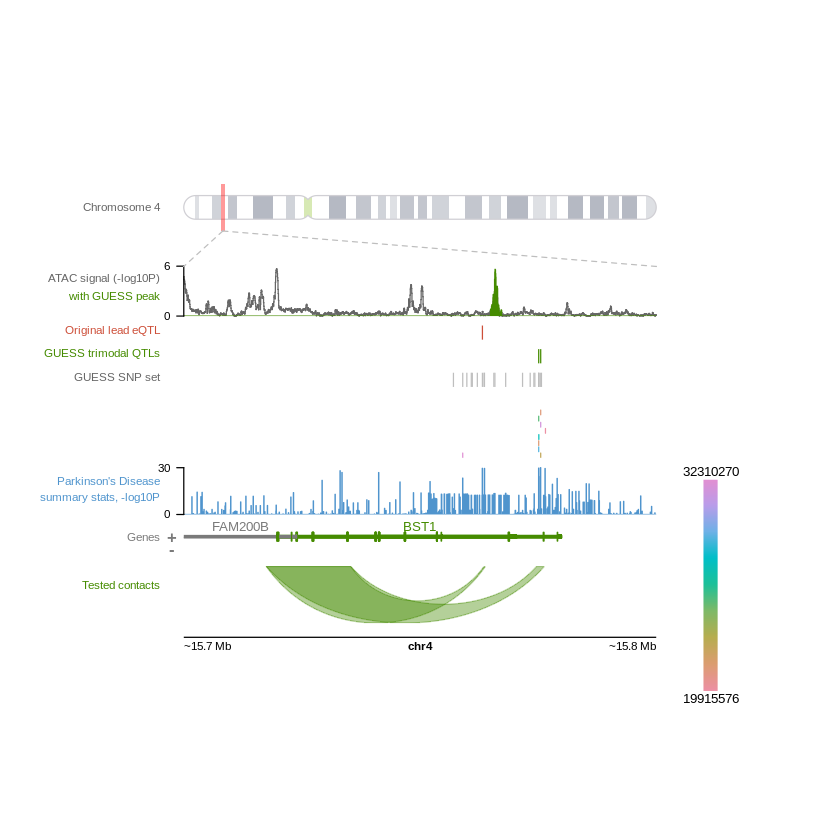

In [9]:
### Plot a couple of GWAS loci.

# rs4698412 and rs11724635 in BST1
park1 <- guess_hg38_peaks[`Triplet name` %like% "BST1" & `Post-proc. FDR mPPI SNP single` == "4:15737348:G:A"]
park2 <- guess_hg38_peaks[`Triplet name` %like% "BST1" & `Post-proc. FDR mPPI SNP single` == "4:15737101:C:A"]

pdf(file = "~/HRJ_monocytes/paper/GWAS_BST1_parkinson_V02.pdf")

### Set region parameters
mychrom = "chr4"
mystart = 15691617
myend = 15750000
###

########## Set parameters main and text
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", default.units = "cm",
                      x = 3, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

########################## 
GUESSvarloc1 = park1$position 
GUESSvarloc2 = park2$position 

myGene = "BST1"
myset = park1$`Triplet ID` # they are triplet ids 6893 and 6894 but both with 21 snps, probably the same. these were the only
# sig snps for this locis (guess[`Triplet name` %like% "ENSG00000109743_BST1" & `Numb. SNP` == 21])
mypeakstart = park1$ATAC_left # same peak
mypeakend = park1$ATAC_right
mybait1 = "4469467"
mybait2 = "4469482"

###
mysetbed <- sets_bed[set == myset]
### original eQTL (See above) ???
myeQTLpos1 <- 15728523 # need hg38 # rs34559912 # in very high LD with the contact QTLs - great
myeQTLpos2 <- 15593692 # this is too far away rs13142069 and not in LD

# rs34559912 to rs4698412 R2 == 0.972
# rs34559912 to rs11724635 R2 == 0.972
# The two contact QTLs are in perfect LD

### restrict called regions to that in BaseQTL
regions_keep1 <- regions[V7 %like% mybait1 & V7 %like% myGene] 
regions_keep_LHS1 <- regions_keep1[, .(chrom1, V2, V3)]
regions_keep_RHS1 <- regions_keep1[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort1 <- setorder(regions_keep_RHS1, cols = "V5")
regions_keep_LHS_merge1 <- regions_keep_LHS1[1:2, ]
RHS_merge1 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort1, d = 1)
LHS_merge1 <- bedtoolsr::bt.merge(regions_keep_LHS1, d = 1)
both_regions1 <- cbind(RHS_merge1, LHS_merge1)
#both_regions1

regions_keep2 <- regions[V7 %like% mybait2 & V7 %like% myGene] 
regions_keep_LHS2 <- regions_keep2[, .(chrom1, V2, V3)]
regions_keep_RHS2 <- regions_keep2[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort2 <- setorder(regions_keep_RHS2, cols = "V5")
regions_keep_LHS_merge2 <- regions_keep_LHS2[1:2, ]
RHS_merge2 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort2, d = 1)
LHS_merge2 <- bedtoolsr::bt.merge(regions_keep_LHS2, d = 1)
both_regions2 <- cbind(RHS_merge2, LHS_merge2)
#both_regions2

########### START PLOTTING

pageCreate(width = 16, height = 10, default.units = "cm", showGuides = F)

## specify the gene target
geneHighlights <- data.frame("geneName" = c(myGene), "color" = c("chartreuse4")) # 

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 7.1, height = 1)
# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 7.4, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 9.6)

####################### LOOPS

## plot loops
archplot <- plotPairsArches(
    data = both_regions1, params = params_main, y = 8.1, height = 1.2, fill = "chartreuse4", linecolor = "fill", flip = TRUE
)
archplot <- plotPairsArches(
    data = both_regions2, params = params_main, y = 8.1, height = 1.2, fill = "chartreuse4", linecolor = "fill", flip = TRUE
)

# text for loops
plotText(
    label = "Tested contacts", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 8.4, height = 0.5,
)
#######################

####################### EQTLS
### Plot GUESS QTLs
GUESS_1 <- data.table(chrom = c(mychrom), start = c(GUESSvarloc1 - 1),  end= c(GUESSvarloc1))
plotRanges( 
    data = GUESS_1, params = params_main, fill = "chartreuse4", linecolor = "fill", collapse = T,
    y = 3.5, height = 0.3
)
GUESS_2 <- data.table(chrom = c(mychrom), start = c(GUESSvarloc2 - 1),  end= c(GUESSvarloc2))
plotRanges( 
    data = GUESS_2, params = params_main, fill = "chartreuse4", linecolor = "fill", collapse = T,
    y = 3.5, height = 0.3
)

# text for QTLs
plotText(
    label = "GUESS trimodal QTLs", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 3.5, height = 0.5,
)

### plot original eQTLs
EX_1 <- data.table(chrom = c(mychrom), start = c(myeQTLpos1 - 1), end= c(myeQTLpos1))
plotRanges( 
    data = EX_1, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 3, height = 0.3
)
#EX_2 <- data.table(chrom = c(mychrom), start = c(myeQTLpos2 - 1), end= c(myeQTLpos2))
#plotRanges( 
#    data = EX_2, params = params_main, linecolor="cornflowerblue", fill = "cornflowerblue", collapse = T,
#    y = 2, height = 0.3
#)

# text for eQTLs
plotText(
    label = "Original lead eQTL", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3, height = 0.5,
)

#######################

####################### SETS

# Plot proxies
plotRanges( 
    data = mysetbed, params = params_main, linecolor="gray", fill = "gray", collapse = T,
    y = 4, height = 0.3
)
# text for proxies
plotText(
    label = "GUESS SNP set", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 4, height = 0.5
)
#######################

####################### ATAC
### wonder if I can plot all ATAC and highlight top?

atac_myregion <- readBigwig(file = "/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 1.8, units = "cm",
    linecolor = "gray40", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)

## plot ATAC top
atac_myregion <- readBigwig(file = "/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mypeakstart,
                        chromend = mypeakend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 1.8, units = "cm",
    linecolor = "chartreuse4", fill = "chartreuse4", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
# text for ATAC, non peak
plotText(
    label = "ATAC signal (-log10P)", fontsize = 7, fontcolor = "gray40",
    rot = 0, params = params_text, y = 1.9, height = 1
) 
# text for ATAC
plotText(
    label = "with GUESS peak", fontsize = 7, fontcolor = "chartreuse4",
    rot = 0, params = params_text, y = 2.3, height = 1
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,6), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1.8, height = 1, fontsize = 7, fontcolor = "chartreuse4", units = "cm"
)

#######################

### How to plot GWAS variants?
### Get the GWAS signal for Parkinson. Got summary stats for Nalls et al., 2019.
### will have to liftover. See previous chunk.

# can we plot signal?
parkinson_hg38_myregion <- parkinson_hg38[start >= mystart & end <= myend]
parkinson_hg38_myregion[, chrom := paste0("chr", chr)]
parkinson_hg38_myregion_plot <- parkinson_hg38_myregion[, .(chrom, start, end, score)]
gwas_signal <- plotSignal(
    data = parkinson_hg38_myregion_plot,
    params = params_main, height = 1, y = 6, units = "cm",
    linecolor = "steelblue3", fill = "steelblue3", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
# range for GWAS
annoYaxis(
    gwas_signal,
    at = c(0,30), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 6, height = 1, fontsize = 7, fontcolor = "goldenrod3", units = "cm"
)
# text for GWAS
plotText(
    label = "Parkinson's Disease\n summary stats, -log10P", fontsize = 7, fontcolor = "steelblue3",
    rot = 0, params = params_text, y = 6.2, height = 1
) 

### Add enhancer stuff?

## papers:
# www.ncbi.nlm.nih.gov/pubmed/21292315
# www.ncbi.nlm.nih.gov/pubmed/25064009
# www.ncbi.nlm.nih.gov/pubmed/28892059 # this is the largest one
# www.ncbi.nlm.nih.gov/pubmed/31701892
# www.ncbi.nlm.nih.gov/pubmed/22451204
# www.ncbi.nlm.nih.gov/pubmed/21084426
# www.ncbi.nlm.nih.gov/pubmed/35970579

## highlighted region on the chromosome

ideogramPlot <- plotIdeogram(
    default.units = "cm",
    x = 3, width = 10, just = c("left", "top"), 
    chrom = mychrom, assembly = "hg38",
    orientation = "h",
    y = 0.25, height = 0.5
)
#region <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend)
annoHighlight(plot = ideogramPlot, chromstart = mystart-700000, chromend = myend+700000,
    params = params_main, fill = "red", y = 0, height = 1
)

annoZoomLines(
    plot = ideogramPlot, params = params_main,
    y0 = 1, y1 = 1.75, x1 = c(3, 13)
)
# text for chromosome
plotText(
    label = "Chromosome 4", fontsize = 7, fontcolor = "gray40",
    rot = 0, params = params_text, y = 0.4, height = 1
) 

## highlight the intersection between guess and GWAS
#annoHighlight(plot = gwas_signal, chromstart = GUESSvarloc2-400, chromend = GUESSvarloc1+400,
#    params = params_main, fill = "gray", y = 1.8, height = 7.5
#)

gwas_catalog_myregion <- unique(gwas_bed[chrom == mychrom & position0 >= mystart & CHR_POS <= myend & `DISEASE/TRAIT` %like% "arkinson"])
### add the GWAS catalog

colors <- mapColors(vector = unique(gwas_catalog_myregion$PUBMEDID),
             palette = colorRampPalette(grDevices::hcl.colors(length(unique(gwas_catalog_myregion$PUBMEDID)), 
                                                 palette = "Set2")))

myids <- copy(gwas_catalog_myregion)
setorder(myids, -PUBMEDID)
check_colors <- data.table(PUBMEDID = unique(myids$PUBMEDID), 
                          color = colors)

gwas_catalog <- plotRanges(
    data = gwas_catalog_myregion, collapse = F, boxHeight = 0.1,
    params = params_main, height = 1.3, y = 4.5, 
    fill = colors,
    linecolor = "fill",
    baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
annoHeatmapLegend(
    plot = gwas_catalog, fontcolor = "black",
    x = 14, y = 6, params = params_main,
    width = 0.3, height = 5, fontsize = 8
)

# range for GWAS
#annoYaxis(
#    gwas_signal,
#    at = c(0,30), label = T, # top -log10P val
#    main = TRUE, axisLine = T, params = params_main, y = 4.5, height = 1, fontsize = 7, fontcolor = "goldenrod3", units = "cm"
#)
# text for GWAS
#plotText(
#    label = "Parkinson's Disease\n summary stats, -log10P", fontsize = 7, fontcolor = "steelblue3",
#    rot = 0, params = params_text, y = 4.7, height = 1
#) 

dev.off()

In [58]:
gwas_catalog_myregion

chrom,position0,CHR_POS,score,SNPS,DISEASE/TRAIT,PUBMEDID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
chr4,15726089,15726090,14.73180,rs6449168,Parkinson's disease,32310270
chr4,15735724,15735725,63.77924,rs4698412,Parkinson's disease or first degree relation to individual with Parkinson's disease,31701892
chr4,15736313,15736314,19.62465,rs4538475,Parkinson's disease,19915576
chr4,15735477,15735478,36.84136,rs11724635,Parkinson's disease,21292315
chr4,15735724,15735725,15.01948,rs4698412,Parkinson's disease,22451204
chr4,15735724,15735725,13.12236,rs4698412,Parkinson's disease,21084426
chr4,15735477,15735478,39.24931,rs11724635,Parkinson's disease,25064009
chr4,15735477,15735478,43.74912,rs11724635,Parkinson's disease,28892059
chr4,15735494,15735495,23.24899,rs4266290,Parkinson's disease,27182965


In [11]:
# prepare leukocyte GWAS data
options(scipen = 999)

# used ~/bin/liftOver GCST90002389_buildGRCh37_chr17.bed ~/bin/liftover/hg19ToHg38_nochr.over.chain GCST90002389_buildGRCh38_chr17.bed GCST90002389_chr17_umapped
# remove weird chromosomes sed -i '/alt/d' GCST90002389_buildGRCh38_chr17.bed
# sort -k1,1n -k2,2n GCST90002389_buildGRCh38_chr17.bed > GCST90002389_buildGRCh38_chr17_sorted.bed
# then bedtools merge -i GCST90002389_buildGRCh38_chr17_sorted.bed -c 4 -o mean  > GCST90002389_buildGRCh38_chr17_sorted_merged.bed
# because there were some overlapping SNPs I think
lymph_hg38 <- fread("~/HRJ_monocytes/external_data/gwas/lymphocyte_perc_white_cells/GCST90002389_buildGRCh38_chr17_sorted_merged.bed")
#lymph_hg38
lymph_hg38[, score := -log(V4)]
lymph_hg38[, V4 := NULL]
setnames(lymph_hg38, c("V1", "V2", "V3"), c("chr", "start", "end"))

genes[genes1]

text[text1]

Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

arches[arches1]

arches[arches2]

arches[arches3]

text[text2]

ranges[ranges1]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

ranges[ranges4]

text[text2]

signal[signal1]

signal[signal2]

text[text2]

text[text2]

yaxis[yaxis1]

signal[signal3]

yaxis[yaxis2]

text[text2]

ideogram[ideogram1]

highlight[highlight1]

zoom[zoom1]

text[text2]

highlight[highlight2]

ranges[ranges5]

heatmapLegend[heatmapLegend1]



null device 
          1

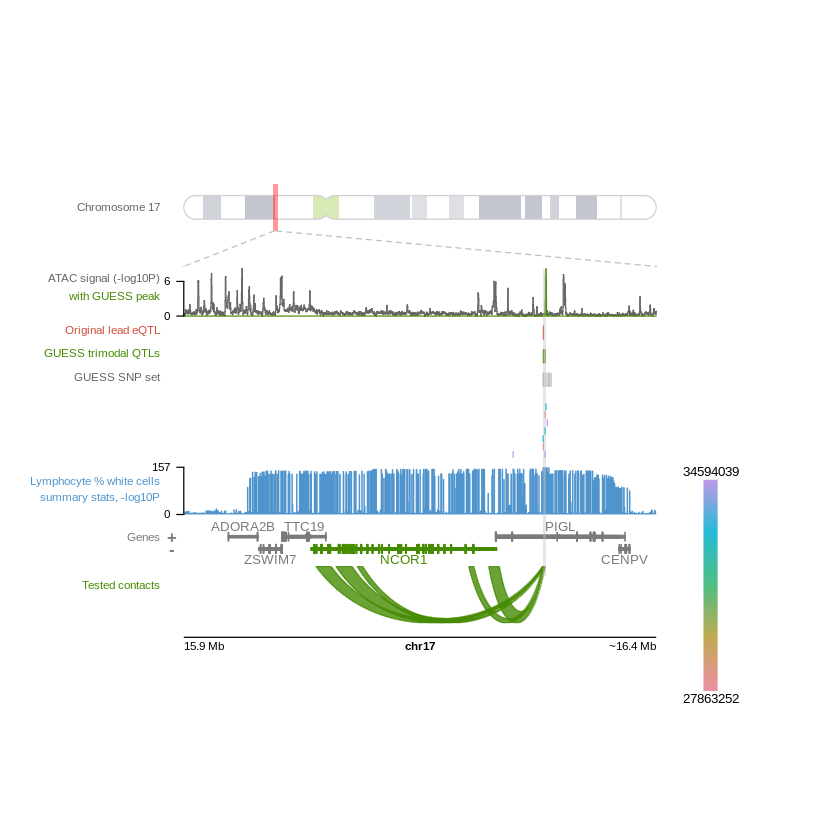

In [12]:
### GWAS NCOR1 locus.

# 
NCOR_1 <- guess_hg38_peaks[`Triplet name` == "X2496951_ENSG00000141027_NCOR1/Peak_44138/ENSG00000141027_NCOR1" & `Post-proc. FDR mPPI SNP single` == "17:16169009:G:A"]
NCOR_2 <- guess_hg38_peaks[`Triplet name` %like% "NCOR1" & `Post-proc. FDR mPPI SNP single` == "17:16170764:C:A"]
#NCOR_3 <- guess_hg38_peaks[`Triplet name` %like% "NCOR1" & `Post-proc. FDR mPPI SNP single` == "17:16188419:G:A"]


pdf(file = "~/HRJ_monocytes/paper/GWAS_NCOR1_blood_V02.pdf")

### Set region parameters
mychrom = "chr17"
mystart = 15900000
myend = 16380433
###

########## Set parameters main and text
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", default.units = "cm",
                      x = 3, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

########################## 
GUESSvarloc1 = NCOR_1$position 
GUESSvarloc2 = NCOR_2$position 
#GUESSvarloc3 = NCOR_3$position 

myGene = "NCOR1"
#myset = NCOR_1$`Triplet ID` # 2783, but I think the fourth variant is in a dif set. see if it comes up
myset = 2783
# it also had a dif atac peak. maybe dont plot it
mypeakstart = NCOR_1$ATAC_left # same peak
mypeakend = NCOR_1$ATAC_right
mybait1 = "2496951"
mybait2 = "2496953"
mybait3 = "2496958"

###
mysetbed <- sets_bed[set == myset]
### original eQTL (See above) ???
myeQTLpos1 <- GUESSvarloc1 # the same snp, rs9910148


### restrict called regions to that in BaseQTL
regions_keep1 <- regions[V7 %like% mybait1 & V7 %like% myGene] 
regions_keep_LHS1 <- regions_keep1[, .(chrom1, V2, V3)]
regions_keep_RHS1 <- regions_keep1[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort1 <- setorder(regions_keep_RHS1, cols = "V5")
regions_keep_LHS_merge1 <- regions_keep_LHS1[1:2, ]
RHS_merge1 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort1, d = 1)
LHS_merge1 <- bedtoolsr::bt.merge(regions_keep_LHS1, d = 1)
both_regions1 <- cbind(RHS_merge1, LHS_merge1)
#both_regions1

regions_keep2 <- regions[V7 %like% mybait2 & V7 %like% myGene] 
regions_keep_LHS2 <- regions_keep2[, .(chrom1, V2, V3)]
regions_keep_RHS2 <- regions_keep2[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort2 <- setorder(regions_keep_RHS2, cols = "V5")
regions_keep_LHS_merge2 <- regions_keep_LHS2[1:2, ]
RHS_merge2 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort2, d = 1)
LHS_merge2 <- bedtoolsr::bt.merge(regions_keep_LHS2, d = 1)
both_regions2 <- cbind(RHS_merge2, LHS_merge2)
#both_regions2

regions_keep3 <- regions[V7 %like% mybait3 & V7 %like% myGene] 
regions_keep_LHS3 <- regions_keep3[, .(chrom1, V2, V3)]
regions_keep_RHS3 <- regions_keep3[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort3 <- setorder(regions_keep_RHS3, cols = "V5")
regions_keep_LHS_merge3 <- regions_keep_LHS3[1:2, ]
RHS_merge3 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort3, d = 1)
LHS_merge3 <- bedtoolsr::bt.merge(regions_keep_LHS3, d = 1)
both_regions3 <- cbind(RHS_merge3, LHS_merge3)
#both_regions3

########### START PLOTTING

pageCreate(width = 16, height = 10, default.units = "cm", showGuides = F)

## specify the gene target
geneHighlights <- data.frame("geneName" = c(myGene), "color" = c("chartreuse4")) # 

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 7.1, height = 1)
# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 7.4, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 9.6)

####################### LOOPS

## plot loops
archplot <- plotPairsArches(
    data = both_regions1, params = params_main, y = 8.1, height = 1.2, fill = "chartreuse4", linecolor = "fill", flip = TRUE
)
archplot <- plotPairsArches(
    data = both_regions2, params = params_main, y = 8.1, height = 1.2, fill = "chartreuse4", linecolor = "fill", flip = TRUE
)
archplot <- plotPairsArches(
    data = both_regions3, params = params_main, y = 8.1, height = 1.2, fill = "chartreuse4", linecolor = "fill", flip = TRUE
)

# text for loops
plotText(
    label = "Tested contacts", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 8.4, height = 0.5,
)
#######################


####################### EQTLS
### Plot GUESS QTLs
GUESS_1 <- data.table(chrom = c(mychrom), start = c(GUESSvarloc1 - 1),  end= c(GUESSvarloc1))
plotRanges( 
    data = GUESS_1, params = params_main, fill = "chartreuse4", linecolor = "fill", collapse = T,
    y = 3.5, height = 0.3
)
GUESS_2 <- data.table(chrom = c(mychrom), start = c(GUESSvarloc2 - 1),  end= c(GUESSvarloc2))
plotRanges( 
    data = GUESS_2, params = params_main, fill = "chartreuse4", linecolor = "fill", collapse = T,
    y = 3.5, height = 0.3
)

# text for QTLs
plotText(
    label = "GUESS trimodal QTLs", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 3.5, height = 0.5,
)

### plot original eQTLs
EX_1 <- data.table(chrom = c(mychrom), start = c(myeQTLpos1 - 1), end= c(myeQTLpos1))
plotRanges( 
    data = EX_1, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 3, height = 0.3
)

# text for eQTLs
plotText(
    label = "Original lead eQTL", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3, height = 0.5,
)

#######################

####################### SETS

# Plot proxies
plotRanges( 
    data = mysetbed, params = params_main, linecolor="gray", fill = "gray", collapse = T,
    y = 4, height = 0.3
)
# text for proxies
plotText(
    label = "GUESS SNP set", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 4, height = 0.5
)
#######################
####################### ATAC
### wonder if I can plot all ATAC and highlight top?

atac_myregion <- readBigwig(file = "/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 1.8, units = "cm",
    linecolor = "gray40", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)

## plot ATAC top
atac_myregion <- readBigwig(file = "/rds/general/project/lms-spivakov-analysis/live/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mypeakstart,
                        chromend = mypeakend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 1.8, units = "cm",
    linecolor = "chartreuse4", fill = "chartreuse4", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
# text for ATAC, non peak
plotText(
    label = "ATAC signal (-log10P)", fontsize = 7, fontcolor = "gray40",
    rot = 0, params = params_text, y = 1.9, height = 1
) 
# text for ATAC
plotText(
    label = "with GUESS peak", fontsize = 7, fontcolor = "chartreuse4",
    rot = 0, params = params_text, y = 2.3, height = 1
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,6), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1.8, height = 1, fontsize = 7, fontcolor = "chartreuse4", units = "cm"
)

#######################
### How to plot GWAS variants?
### Get the GWAS signal for lymphocyte percentage white cells Got summary stats for Vuckovic et al, 2020.
### will have to liftover. See previous chunk.

# can we plot signal?
lymph_hg38_myregion <- lymph_hg38[start >= mystart & end <= myend]
lymph_hg38_myregion[, chrom := paste0("chr", chr)]
lymph_hg38_myregion_plot <- lymph_hg38_myregion[, .(chrom, start, end, score)]
gwas_signal <- plotSignal(
    data = lymph_hg38_myregion_plot,
    params = params_main, height = 1, y = 6, units = "cm",
    linecolor = "steelblue3", fill = "steelblue3", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
## range for GWAS
annoYaxis(
    gwas_signal,
    at = c(0,157), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 6, height = 1, fontsize = 7, fontcolor = "goldenrod3", units = "cm"
)
# text for GWAS
plotText(
    label = "Lymphocyte % white cells\n summary stats, -log10P", fontsize = 7, fontcolor = "steelblue3",
    rot = 0, params = params_text, y = 6.2, height = 1
) 


## highlighted region on the chromosome

ideogramPlot <- plotIdeogram(
    default.units = "cm",
    x = 3, width = 10, just = c("left", "top"), 
    chrom = mychrom, assembly = "hg38",
    orientation = "h",
    y = 0.25, height = 0.5
)
#region <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend)
annoHighlight(plot = ideogramPlot, chromstart = mystart-200000, chromend = myend+200000,
    params = params_main, fill = "red", y = 0, height = 1
)

annoZoomLines(
    plot = ideogramPlot, params = params_main,
    y0 = 1, y1 = 1.75, x1 = c(3, 13)
)
# text for chromosome
plotText(
    label = "Chromosome 17", fontsize = 7, fontcolor = "gray40",
    rot = 0, params = params_text, y = 0.4, height = 1
) 

## highlight the intersection between guess and GWAS
annoHighlight(plot = gwas_signal, chromstart = GUESSvarloc1-400, chromend = GUESSvarloc2+400,
    params = params_main, fill = "gray", y = 1.8, height = 6.5
)
### add the GWAS catalog
## need to look at Lymphocyte percentage of white cells and neutrophil count
gwas_catalog_myregion <- unique(gwas_bed[chrom == mychrom & position0 >= mystart & CHR_POS <= myend & `DISEASE/TRAIT` %like% "Lymphocyte percentage" |
                                        chrom == mychrom & position0 >= mystart & CHR_POS <= myend & `DISEASE/TRAIT` %like% "Neutrophil count"])

colors <- mapColors(vector = unique(gwas_catalog_myregion$PUBMEDID),
             palette = colorRampPalette(grDevices::hcl.colors(length(unique(gwas_catalog_myregion$PUBMEDID)), 
                                                 palette = "Set2")))

myids <- copy(gwas_catalog_myregion)
setorder(myids, -PUBMEDID)
check_colors <- data.table(PUBMEDID = unique(myids$PUBMEDID), 
                          color = colors)

gwas_catalog <- plotRanges(
    data = gwas_catalog_myregion, collapse = F, boxHeight = 0.13,
    params = params_main, height = 1.3, y = 4.5, 
    fill = colors,
    linecolor = "fill",
    baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
annoHeatmapLegend(
    plot = gwas_catalog, fontcolor = "black",
    x = 14, y = 6, params = params_main,
    width = 0.3, height = 5, fontsize = 8
)

dev.off()

In [4]:
mychrom = "chr17"
mystart = 15900000
myend = 16380433

gwas_catalog_myregion <- unique(gwas_bed[chrom == mychrom & position0 >= mystart & CHR_POS <= myend & `DISEASE/TRAIT` %like% "Lymphocyte percentage" |
                                        chrom == mychrom & position0 >= mystart & CHR_POS <= myend & `DISEASE/TRAIT` %like% "Neutrophil count"])
gwas_catalog_myregion

unique(gwas_catalog_myregion$PUBMEDID) # five
setorder(gwas_catalog_myregion, position0)
gwas_catalog_myregion

chrom,position0,CHR_POS,score,SNPS,DISEASE/TRAIT,PUBMEDID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
chr17,16267449,16267450,188.91734,rs7210990,Neutrophil count,32888493
chr17,16267449,16267450,184.20681,rs7210990,Neutrophil count,32888493
chr17,16269666,16269667,151.97062,rs71353786,Neutrophil count,32888494
chr17,16234942,16234943,47.25567,rs12936233,Neutrophil count,34469753
chr17,16268373,16268374,58.07545,rs74267027,Neutrophil count,27863252
chr17,16267449,16267450,69.07755,rs7210990,Lymphocyte percentage of white cells,27863252
chr17,16265694,16265695,165.78613,rs9910148,Lymphocyte percentage of white cells,32888494
chr17,16265469,16265470,94.76266,rs12936529,Neutrophil count,34594039


[1] 32888493 32888494 34469753 27863252 34594039

chrom,position0,CHR_POS,score,SNPS,DISEASE/TRAIT,PUBMEDID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
chr17,16234942,16234943,47.25567,rs12936233,Neutrophil count,34469753
chr17,16265469,16265470,94.76266,rs12936529,Neutrophil count,34594039
chr17,16265694,16265695,165.78613,rs9910148,Lymphocyte percentage of white cells,32888494
chr17,16267449,16267450,188.91734,rs7210990,Neutrophil count,32888493
chr17,16267449,16267450,184.20681,rs7210990,Neutrophil count,32888493
chr17,16267449,16267450,69.07755,rs7210990,Lymphocyte percentage of white cells,27863252
chr17,16268373,16268374,58.07545,rs74267027,Neutrophil count,27863252
chr17,16269666,16269667,151.97062,rs71353786,Neutrophil count,32888494


ERROR: Error in .prepareFastSubset(isub = isub, x = x, enclos = parent.frame(), : RHS of == is length 2 which is not 1 or nrow (275075). For robustness, no recycling is allowed (other than of length 1 RHS). Consider %in% instead.


chrom,start,end
<chr>,<dbl>,<int>
chr4,15735724,15735725


In [32]:
parkinson_hg38_myregion_plot[start == end]

chrom,start,end,minuslogP
<chr>,<int>,<int>,<dbl>


In [52]:
setkey(parkinson_hg38_myregion_plot, start)
parkinson_hg38_myregion_plot[unique(parkinson_hg38_myregion_plot[duplicated(parkinson_hg38_myregion_plot)]),which=T]

parkinson_hg38_myregion_plot[,count := .N,by = list(end)][count>1, which=T]
parkinson_hg38_myregion_plot[start == 74434117]


integer(0)

integer(0)

chrom,start,end,minuslogP,count
<chr>,<int>,<int>,<dbl>,<int>
